In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parents[0]  # importing functions from other folders
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from _data.data_utils import read_in
from _fitting.fitting_utils import hist_plot, CI_plot, CI_plot_alt, CI_plot_both, plot_posteriors_side_by_side, plot_spline
import pymc as pm
import pymc.math as pmm
import arviz as az
from patsy import dmatrix
import nutpie
import time
from pprint import pprint
from IPython.display import display
import seaborn as sns
from pymc.variational.callbacks import CheckParametersConvergence

az.style.use("arviz-darkgrid")


if '___laptop' in os.listdir('../'):
    # laptop folder
    folder = "../../_data/p-dengue/"
elif '___server' in os.listdir('../'):
    # server folder
    folder = "../../../../../data/lucaratzinger_data/p_dengue/"

In [2]:
data = read_in(folder, admin=2, max_lag=6, dropna=True, end_year=2018, end_month=12)
data.columns

Index(['admin1', 'admin2', 'year', 'month', 'cases', 'ONI',
       't2m_mean_unweighted(0)', 't2m_mean_pop_weighted(0)',
       't2m_min_unweighted(0)', 't2m_min_pop_weighted(0)',
       ...
       'surveillance_pop_weighted', 'urban_surveillance_nonweighted',
       'urban_surveillance_pop_weighted', 'density_unweighted',
       'density_pop_weighted', 'urban_density_unweighted',
       'urban_density_pop_weighted', 'urbanisation_nonweighted_std',
       'urbanisation_pop_weighted_std', 'ONI_std'],
      dtype='object', length=160)

In [3]:
data

,admin1,admin2,year,month,cases,ONI,t2m_mean_unweighted(0),t2m_mean_pop_weighted(0),t2m_min_unweighted(0),t2m_min_pop_weighted(0),...,surveillance_pop_weighted,urban_surveillance_nonweighted,urban_surveillance_pop_weighted,density_unweighted,density_pop_weighted,urban_density_unweighted,urban_density_pop_weighted,urbanisation_nonweighted_std,urbanisation_pop_weighted_std,ONI_std
0,ACEH,SIMEULUE,2016,1,1.0,2.48,27.17922,27.197840,24.47756,24.526417,...,0.389898,0.774953,0.768781,42.316379,715.475930,296.269231,1066.646631,-0.772373,-1.339194,3.022059
1,ACEH,SIMEULUE,2016,2,8.0,2.14,27.36236,27.382226,24.75063,24.775451,...,0.389898,0.774953,0.768781,42.316379,715.475930,296.269231,1066.646631,-0.772373,-1.339194,2.599967
2,ACEH,SIMEULUE,2016,3,9.0,1.58,27.37810,27.401347,24.88680,24.928477,...,0.389898,0.774953,0.768781,42.316379,715.475930,296.269231,1066.646631,-0.772373,-1.339194,1.904756
3,ACEH,SIMEULUE,2016,4,14.0,0.94,27.39373,27.415193,25.11874,25.147523,...,0.389898,0.774953,0.768781,42.316379,715.475930,296.269231,1066.646631,-0.772373,-1.339194,1.110230
4,ACEH,SIMEULUE,2016,5,4.0,0.39,27.50067,27.520510,25.18392,25.223199,...,0.389898,0.774953,0.768781,42.316379,715.475930,296.269231,1066.646631,-0.772373,-1.339194,0.427433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55435,PAPUA,KOTA JAYAPURA,2018,8,4.0,0.23,25.12360,25.180081,22.03326,22.159867,...,0.858845,0.843776,0.879407,390.301328,29783.772002,3573.737374,31938.276507,-0.471628,1.321452,0.228802
55436,PAPUA,KOTA JAYAPURA,2018,9,7.0,0.49,25.23828,25.295666,22.07794,22.149525,...,0.858845,0.843776,0.879407,390.301328,29783.772002,3573.737374,31938.276507,-0.471628,1.321452,0.551578
55437,PAPUA,KOTA JAYAPURA,2018,10,0.0,0.76,25.49520,25.549852,22.48245,22.502733,...,0.858845,0.843776,0.879407,390.301328,29783.772002,3573.737374,31938.276507,-0.471628,1.321452,0.886769
55438,PAPUA,KOTA JAYAPURA,2018,11,0.0,0.90,25.27160,25.363511,22.75375,22.864150,...,0.858845,0.843776,0.879407,390.301328,29783.772002,3573.737374,31938.276507,-0.471628,1.321452,1.060572


---

In [4]:
def build_model(data, stat_names, type, degree=3, num_knots = 3, knot_type='quantile', orthogonal=True,
                surveillance_name=None, urbanisation_name='urbanisation_pop_weighted_std'):
    model = pm.Model()
    with model:
        # Priors
        alpha = pm.Exponential("alpha", 0.5)
        intercept = pm.Normal("intercept", mu=0, sigma=2.5)
        if urbanisation_name:
            beta_u = pm.Normal("beta_u", mu=0, sigma=1)

        # splines
        knot_list = {}
        B = {}
        B_ = {}
        Q = {}
        R = {}
        sigma_w = {}
        w_raw = {}
        w = {}
        f = {}
        for stat_name in stat_names:
            d = data[stat_name]
            if knot_type=='equispaced':
                knot_list[stat_name] = np.linspace(np.min(d), np.max(d), num_knots+2)[1:-1]
            elif knot_type=='quantile':
                knot_list[stat_name] = np.percentile(d, np.linspace(0, 100, num_knots + 2))[1:-1]
            else:
                print('knot_list must be quantile or equispaced')

            B[stat_name] = dmatrix(f"bs(s, knots=knots, degree=degree, include_intercept=True)-1",
                        {"s": data[stat_name], "knots": knot_list[stat_name], "degree":degree})
            B_[stat_name] = np.asarray(B[stat_name])
            B_[stat_name] = (B_[stat_name] - B_[stat_name].mean(axis=0)) / B_[stat_name].std(axis=0)
            Q[stat_name], R[stat_name] = np.linalg.qr(B_[stat_name])
        
            # Spline coefficients
            sigma_w[stat_name] = pm.HalfNormal(f"sigma_w({stat_name})", sigma=0.5)

            if type == 'B w_r':
                # Non-centered standard normals
                w_raw[stat_name] = pm.Normal(f"w_raw({stat_name})", mu=0, sigma=1, size=B[stat_name].shape[1], dims="splines")
                w[stat_name] = pm.Deterministic(f"w({stat_name})", w_raw[stat_name])
                # Spline contribution (with scaled mean to zero soft constraint)
                f_raw = pm.math.dot(B[stat_name], sigma_w[stat_name]* w[stat_name])
            elif type == 'B_ w_r':
                # Non-centered standard normals
                w_raw[stat_name] = pm.Normal(f"w_raw({stat_name})", mu=0, sigma=1, size=B[stat_name].shape[1], dims="splines")
                w[stat_name] = pm.Deterministic(f"w({stat_name})", w_raw[stat_name])
                # Spline contribution (with scaled mean to zero soft constraint)
                f_raw = pm.math.dot(B_[stat_name], sigma_w[stat_name]* w[stat_name])
            elif type == 'Q (R w_raw)':
                w_raw[stat_name] = pm.Normal(f"w_raw({stat_name})", mu=0, sigma=1, size=B[stat_name].shape[1], dims="splines")
                # Linear transform to get correlated beta
                w[stat_name] = pm.Deterministic(f"w({stat_name})", pmm.dot(R[stat_name], w_raw[stat_name]))
                # Spline contribution (with scaled mean to zero soft constraint)
                f_raw = pm.math.dot(Q[stat_name], sigma_w[stat_name]* w[stat_name])
            elif type == 'Q w':
                cov_w = R[stat_name] @ R[stat_name].T  # covariance for w
                w[stat_name] = pm.MvNormal(
                    f"w({stat_name})",
                    mu=np.zeros(B[stat_name].shape[1]),
                    cov=cov_w,
                    shape=B[stat_name].shape[1],
                    dims="splines",)
                f_raw = pm.math.dot(Q[stat_name], sigma_w[stat_name]* w[stat_name])

            # this mean divided by std constraint encourages the spline to be centered around zero,
            # but does not punish variance (which arises from scale and curve variance)
            f_mean = pm.math.mean(f_raw)
            f_var  = pm.math.mean((f_raw - f_mean) ** 2)
            f_std = pm.math.sqrt(f_var + 1e-6)
            pm.Potential(
            f"f_centred_prior({stat_name})",
            pm.logp(pm.Normal.dist(mu=0.0, sigma=0.01), f_mean/(f_std+1e-6)))
            f[stat_name] = f_raw

        # Link
        log_mu = intercept + pm.math.log(data['population'])
        if surveillance_name:
            log_mu += pm.math.log(data[surveillance_name]+1e-3)
        if urbanisation_name:
            log_mu += beta_u*data[urbanisation_name]
        for stat_name in stat_names:
            log_mu += f[stat_name]

        # Likelihood
        y_obs = pm.NegativeBinomial('y_obs', mu=pm.math.exp(log_mu), alpha=alpha, observed=data['cases'])

    if type == 'B w_r':
        return model, B, knot_list
    else:
        return model, Q, knot_list

In [5]:
model_settings = {}
model = {}
idata = {}
times = {}
eval_waic = {}
eval_psis_loo_elpd = {}
model_B = {}
model_Q = {}
model_R = {}
model_knot_list = {}

In [6]:
stat_names = ['tp_24hmean_pop_weighted_log(1)']

In [7]:
for type in ['B_ w_r', 'B w_r']:
    model_name = f"[{type}]_tp_24hmean_p_log(1)"

    model_settings[model_name] = {'data':data.copy(), 'stat_names':stat_names, 'type':type,
                                  'degree':3, 'num_knots':5, 'knot_type':'quantile', 'orthogonal':True,
                                  'surveillance_name':None, 'urbanisation_name':'urbanisation_pop_weighted_std'}
    model[model_name], model_B[model_name], model_knot_list[model_name] = build_model(**model_settings[model_name])

In [8]:
for model_name in model.keys():
    print(model_name)
    with model[model_name]:
        s0 = time.time()
        idata[model_name] = pm.sample(tune=1000, draws=1500, chains=4, random_seed=42,
                                    discard_tuned_samples=True, nuts_sampler="nutpie", store_divergences=True)
        s1 = time.time()
        pm.compute_log_likelihood(idata[model_name], progressbar=False)
        s2 = time.time()
        times[model_name] = (s1 - s0, s2 - s1)
        print(f'Posterior Sampling {s1 - s0:.2f} seconds')
        print(f'Log Likelihood Compute {s2 - s1:.2f} seconds')

[B_ w_r]_tp_24hmean_p_log(1)


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2500,32,0.28,31
,2500,18,0.27,31
,2500,8,0.27,15
,2500,5,0.28,31


Posterior Sampling 308.42 seconds
Log Likelihood Compute 3.89 seconds
[B w_r]_tp_24hmean_p_log(1)


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2500,12,0.26,15
,2500,4,0.24,15
,2500,21,0.27,15
,2500,49,0.26,15


Posterior Sampling 261.08 seconds
Log Likelihood Compute 3.75 seconds


[B_ w_r]_tp_24hmean_p_log(1)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-10.106,0.012,-10.130,-10.084,0.000,0.000,6700.0,4215.0,1.00
alpha,0.397,0.005,0.388,0.405,0.000,0.000,6463.0,3181.0,1.00
beta_u,0.189,0.013,0.164,0.214,0.000,0.000,6174.0,3499.0,1.00
sigma_w(tp_24hmean_pop_weighted_log(1)),0.164,0.045,0.091,0.253,0.002,0.001,759.0,753.0,1.01
w(tp_24hmean_pop_weighted_log(1))[0],-0.303,0.171,-0.627,0.010,0.004,0.002,2252.0,3595.0,1.00
w(tp_24hmean_pop_weighted_log(1))[1],-0.871,0.355,-1.570,-0.274,0.010,0.006,1181.0,1009.0,1.00
w(tp_24hmean_pop_weighted_log(1))[2],-1.976,0.570,-3.029,-0.934,0.019,0.011,863.0,722.0,1.00
w(tp_24hmean_pop_weighted_log(1))[3],0.525,0.607,-0.583,1.727,0.017,0.012,1240.0,1682.0,1.00
w(tp_24hmean_pop_weighted_log(1))[4],0.289,0.461,-0.606,1.147,0.013,0.009,1237.0,1715.0,1.00
w(tp_24hmean_pop_weighted_log(1))[5],0.457,0.576,-0.611,1.571,0.016,0.011,1258.0,1656.0,1.00


[B w_r]_tp_24hmean_p_log(1)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-10.105,0.014,-10.130,-10.080,0.000,0.000,6210.0,3373.0,1.00
alpha,0.397,0.004,0.389,0.405,0.000,0.000,6922.0,4148.0,1.00
beta_u,0.190,0.013,0.166,0.215,0.000,0.000,6610.0,4073.0,1.00
sigma_w(tp_24hmean_pop_weighted_log(1)),1.243,0.233,0.818,1.674,0.010,0.008,579.0,562.0,1.00
w(tp_24hmean_pop_weighted_log(1))[0],-1.125,0.575,-2.201,-0.059,0.010,0.009,3463.0,3053.0,1.00
w(tp_24hmean_pop_weighted_log(1))[1],-1.664,0.489,-2.553,-0.746,0.014,0.009,1139.0,960.0,1.00
w(tp_24hmean_pop_weighted_log(1))[2],-1.864,0.370,-2.511,-1.201,0.014,0.009,692.0,717.0,1.00
w(tp_24hmean_pop_weighted_log(1))[3],0.260,0.058,0.156,0.365,0.002,0.001,920.0,1692.0,1.00
w(tp_24hmean_pop_weighted_log(1))[4],0.208,0.059,0.101,0.315,0.002,0.001,1133.0,807.0,1.00
w(tp_24hmean_pop_weighted_log(1))[5],0.223,0.055,0.128,0.330,0.002,0.001,1068.0,1402.0,1.00


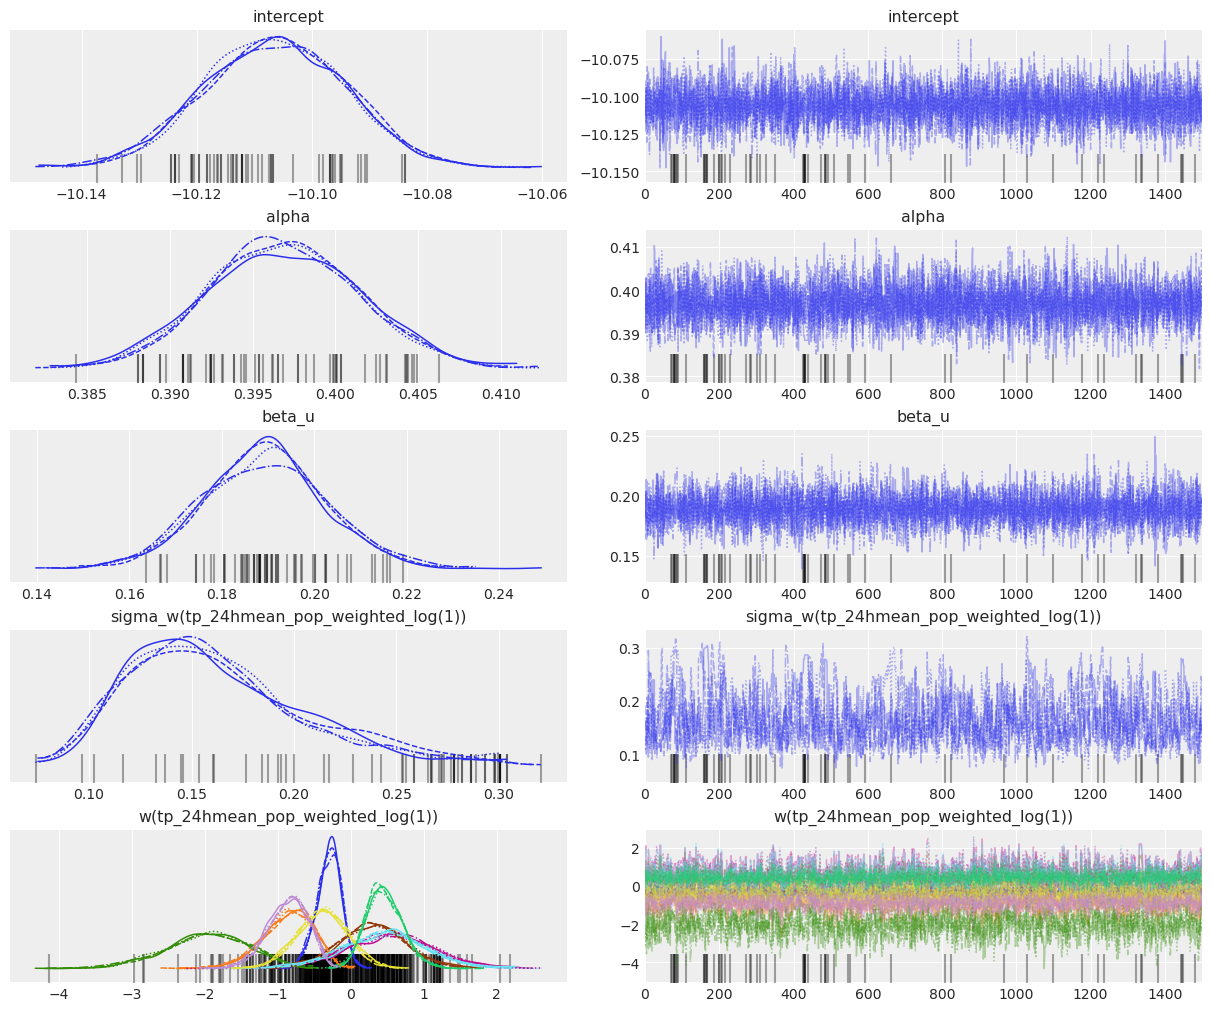

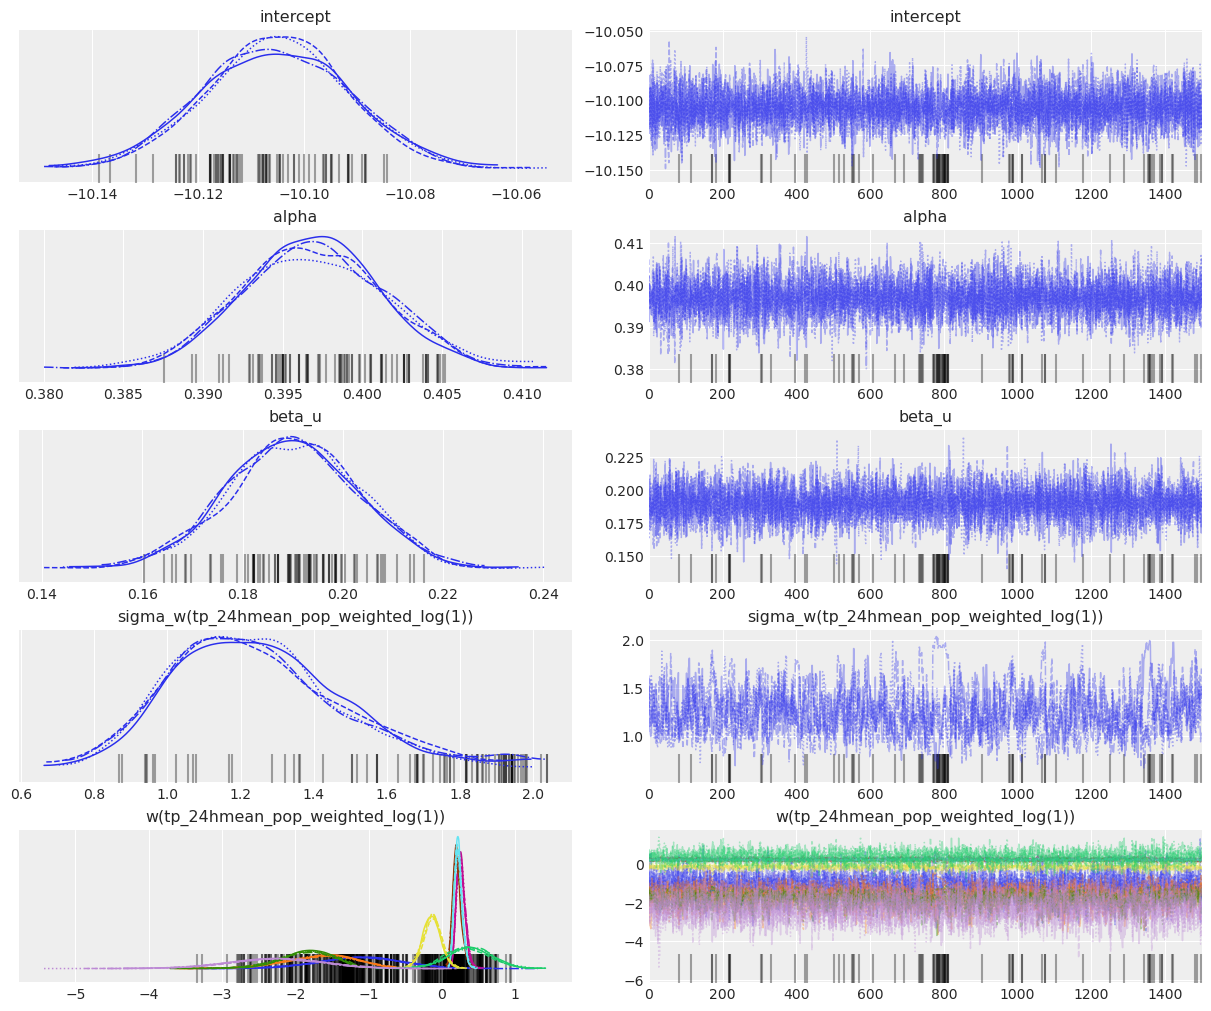

In [9]:
for model_name in model.keys():
    print(model_name)
    # 0.01
    var_names = ['intercept', 'alpha', 'beta_u'] + [f'sigma_w({stat_name})' for stat_name in stat_names] + [f'w({stat_name})' for stat_name in stat_names]
    display(az.summary(idata[model_name], var_names=var_names))
    az.plot_trace(idata[model_name], var_names=var_names);

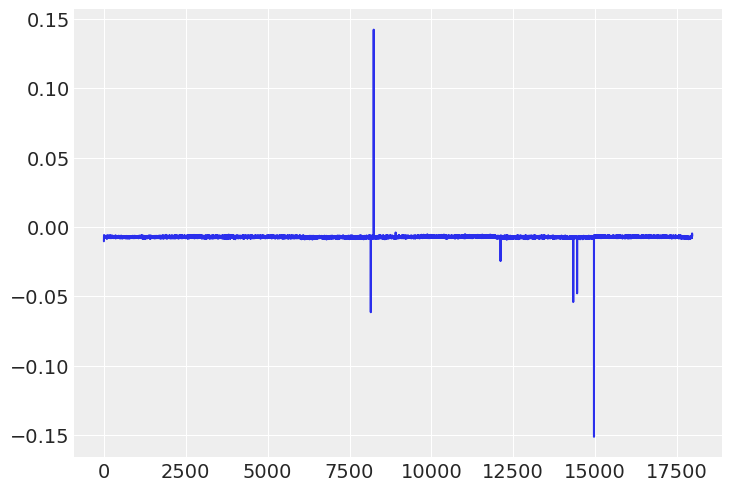

In [29]:
model_name = "[B_ w_r]_tp_24hmean_p_log(1)"
d = np.array(data[stat_name])
id = np.argsort(d)
d = d[id]
b = model_B[model_name][stat_name]
b = b[id, -1]
# b = (b - b.mean(axis=0))/b.std(axis=0)  # center basis functions for better visualization
plt.plot(b)
plt.show()

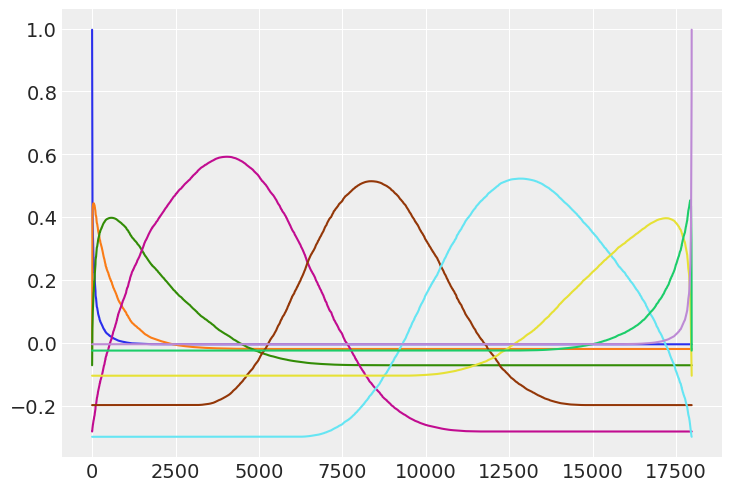

In [25]:
model_name = "[B w_r]_tp_24hmean_p_log(1)"
d = np.array(data[stat_name])
id = np.argsort(d)
d = d[id]
b = model_B[model_name][stat_name]
b = b[id, :]
b = (b - b.mean(axis=0))  # center basis functions for better visualization
plt.plot(b)
plt.show()

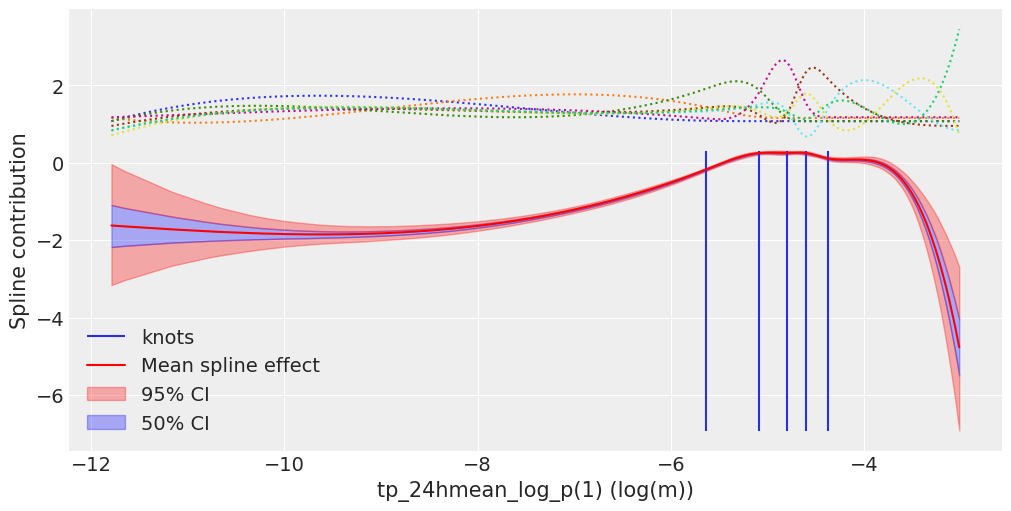

In [30]:
model_name = "[B_ w_r]_tp_24hmean_p_log(1)"
for stat_name in model_settings[model_name]['stat_names']:
        b = model_B['[B w_r]_tp_24hmean_p_log(1)'][stat_name]
        b = (b - b.mean(axis=0))/b.std(axis=0)  # center basis functions for better visualization
        plot_spline(idata[model_name], stat_name, f'w({stat_name})', f'sigma_w({stat_name})',
                    b, data[stat_name],
                    knots=model_knot_list[model_name][stat_name],
                    show_basis=True, basis_scale=8, invert_log=False)

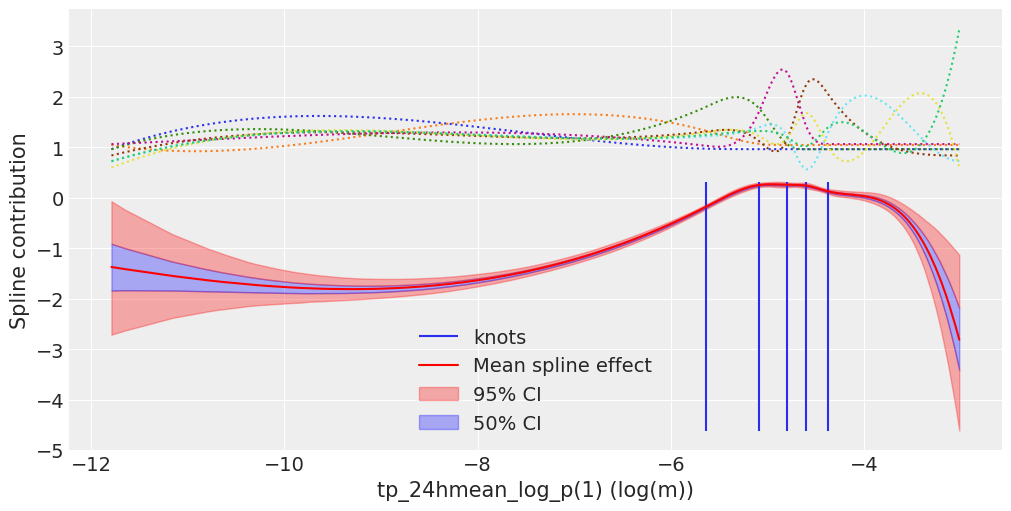

In [11]:
model_name = "[B w_r]_tp_24hmean_p_log(1)"
for stat_name in model_settings[model_name]['stat_names']:
        plot_spline(idata[model_name], stat_name, f'w({stat_name})', f'sigma_w({stat_name})',
                    model_B[model_name][stat_name], data[stat_name],
                    knots=model_knot_list[model_name][stat_name],
                    show_basis=True, basis_scale=8, invert_log=False)

---

In [18]:
for type in ['B w_r', 'Q (R w_raw)', 'Q w']:
    model_name = f"[{type}]_tp_24hmean_p_log(1)"

    model_settings[model_name] = {'data':data.copy(), 'stat_names':stat_names, 'type':type,
                                  'degree':3, 'num_knots':5, 'knot_type':'quantile', 'orthogonal':True,
                                  'surveillance_name':None, 'urbanisation_name':'urbanisation_pop_weighted_std'}
    model[model_name], model_B[model_name], model_knot_list[model_name] = build_model(**model_settings[model_name])

---

In [19]:
for model_name in model.keys():
    print(model_name)
    with model[model_name]:
        s0 = time.time()
        idata[model_name] = pm.sample(tune=1000, draws=1500, chains=4, random_seed=42,
                                    discard_tuned_samples=True, nuts_sampler="nutpie", store_divergences=True)
        s1 = time.time()
        pm.compute_log_likelihood(idata[model_name], progressbar=False)
        s2 = time.time()
        times[model_name] = (s1 - s0, s2 - s1)
        print(f'Posterior Sampling {s1 - s0:.2f} seconds')
        print(f'Log Likelihood Compute {s2 - s1:.2f} seconds')

[B w_r]_tp_24hmean_p_log(1)


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2500,12,0.26,15
,2500,4,0.24,15
,2500,21,0.27,15
,2500,49,0.26,15


Posterior Sampling 258.99 seconds
Log Likelihood Compute 3.84 seconds
[Q (R w_raw)]_tp_24hmean_p_log(1)


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2500,95,0.28,31
,2500,23,0.26,31
,2500,491,0.24,15
,2500,10,0.24,31


Posterior Sampling 284.16 seconds
Log Likelihood Compute 3.87 seconds
[Q w]_tp_24hmean_p_log(1)


Progress,Draws,Divergences,Step Size,Gradients/Draw
,493,0,0.00,1023
,324,0,0.00,3
,443,0,0.00,1023
,437,0,0.01,1023


Posterior Sampling 665.58 seconds
Log Likelihood Compute 0.13 seconds


/mnt/b1/lucaratzinger/miniconda3/envs/p-dengue-py311/lib/python3.11/site-packages/arviz/data/base.py:272: UserWarning: More chains (4) than draws (0). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


In [20]:
times

{'[B w_r]_tp_24hmean_p_log(1)': (258.99279975891113, 3.8442513942718506),
 '[Q (R w_raw)]_tp_24hmean_p_log(1)': (284.16417264938354, 3.8728079795837402),
 '[Q w]_tp_24hmean_p_log(1)': (665.5769000053406, 0.13105988502502441)}

[B w_r]_tp_24hmean_p_log(1)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-10.105,0.014,-10.130,-10.080,0.000,0.000,6210.0,3373.0,1.00
alpha,0.397,0.004,0.389,0.405,0.000,0.000,6922.0,4148.0,1.00
beta_u,0.190,0.013,0.166,0.215,0.000,0.000,6610.0,4073.0,1.00
sigma_w(tp_24hmean_pop_weighted_log(1)),1.243,0.233,0.818,1.674,0.010,0.008,579.0,562.0,1.00
w(tp_24hmean_pop_weighted_log(1))[0],-1.125,0.575,-2.201,-0.059,0.010,0.009,3463.0,3053.0,1.00
w(tp_24hmean_pop_weighted_log(1))[1],-1.664,0.489,-2.553,-0.746,0.014,0.009,1139.0,960.0,1.00
w(tp_24hmean_pop_weighted_log(1))[2],-1.864,0.370,-2.511,-1.201,0.014,0.009,692.0,717.0,1.00
w(tp_24hmean_pop_weighted_log(1))[3],0.260,0.058,0.156,0.365,0.002,0.001,920.0,1692.0,1.00
w(tp_24hmean_pop_weighted_log(1))[4],0.208,0.059,0.101,0.315,0.002,0.001,1133.0,807.0,1.00
w(tp_24hmean_pop_weighted_log(1))[5],0.223,0.055,0.128,0.330,0.002,0.001,1068.0,1402.0,1.00


[Q (R w_raw)]_tp_24hmean_p_log(1)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-10.106,0.013,-10.131,-10.084,0.001,0.000,449.0,506.0,1.01
alpha,0.397,0.005,0.388,0.406,0.000,0.000,459.0,593.0,1.01
beta_u,0.189,0.013,0.165,0.212,0.001,0.000,600.0,3079.0,1.00
sigma_w(tp_24hmean_pop_weighted_log(1)),0.197,0.086,0.095,0.388,0.023,0.019,27.0,25.0,1.13
w(tp_24hmean_pop_weighted_log(1))[0],-181.449,65.870,-286.692,-66.114,12.140,6.495,27.0,25.0,1.11
w(tp_24hmean_pop_weighted_log(1))[1],-258.939,92.836,-405.668,-100.406,16.969,8.756,28.0,24.0,1.11
w(tp_24hmean_pop_weighted_log(1))[2],-138.889,49.927,-219.199,-49.831,9.118,4.990,27.0,25.0,1.11
w(tp_24hmean_pop_weighted_log(1))[3],36.359,15.558,9.351,63.641,2.326,0.321,34.0,174.0,1.08
w(tp_24hmean_pop_weighted_log(1))[4],37.783,17.301,8.831,68.264,2.397,0.448,38.0,80.0,1.08
w(tp_24hmean_pop_weighted_log(1))[5],-53.334,21.233,-89.715,-18.502,3.520,1.264,28.0,41.0,1.10


[Q w]_tp_24hmean_p_log(1)


/mnt/b1/lucaratzinger/miniconda3/envs/p-dengue-py311/lib/python3.11/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/mnt/b1/lucaratzinger/miniconda3/envs/p-dengue-py311/lib/python3.11/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/mnt/b1/lucaratzinger/miniconda3/envs/p-dengue-py311/lib/python3.11/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/mnt/b1/lucaratzinger/miniconda3/envs/p-dengue-py311/lib/python3.11/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/mnt/b1/lucaratzinger/miniconda3/envs/p-dengue-py311/lib/python3.11/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = u

ValueError: Too few elements for interval calculation. 

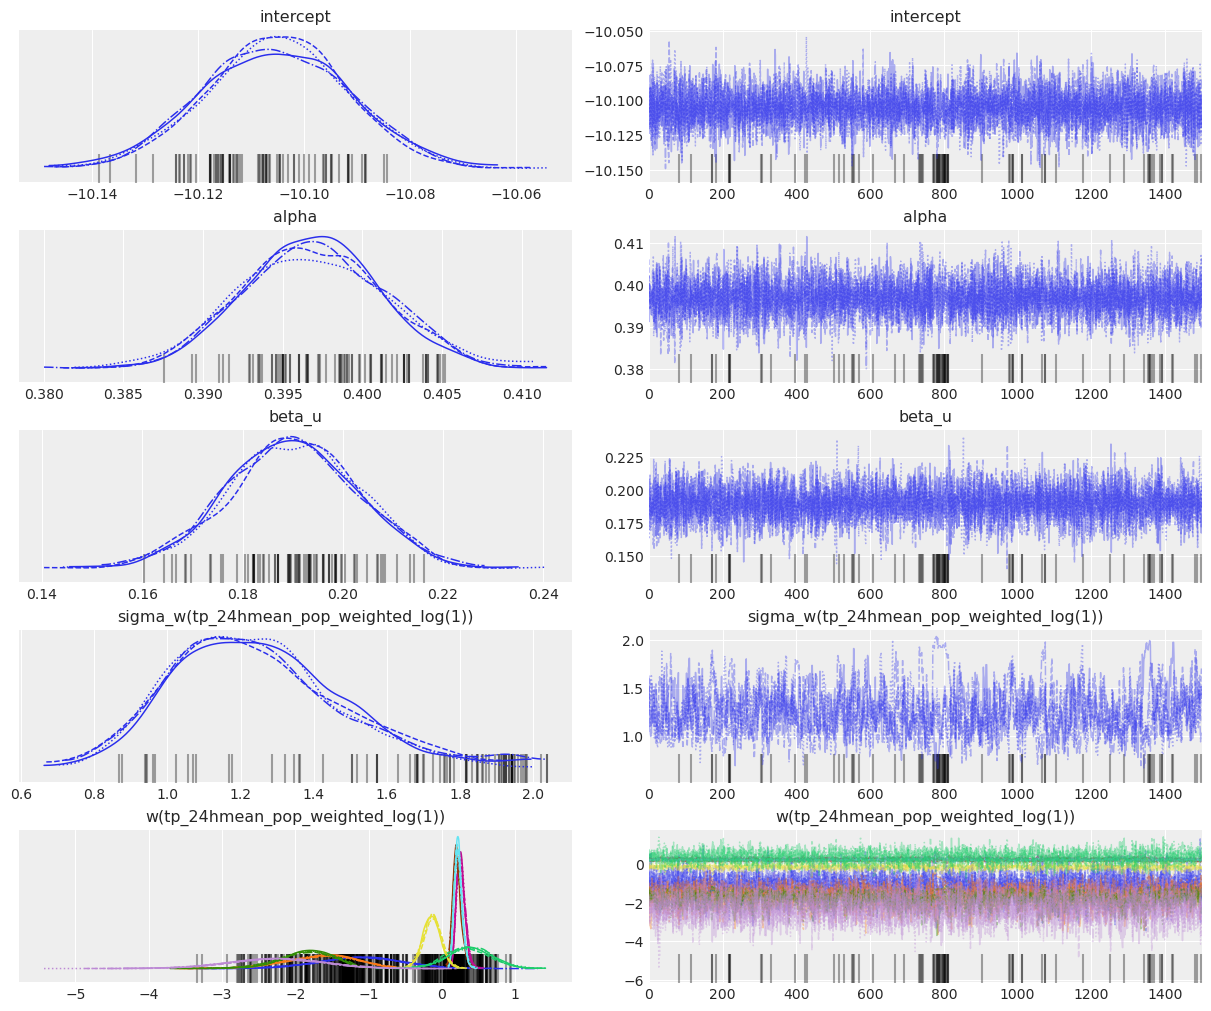

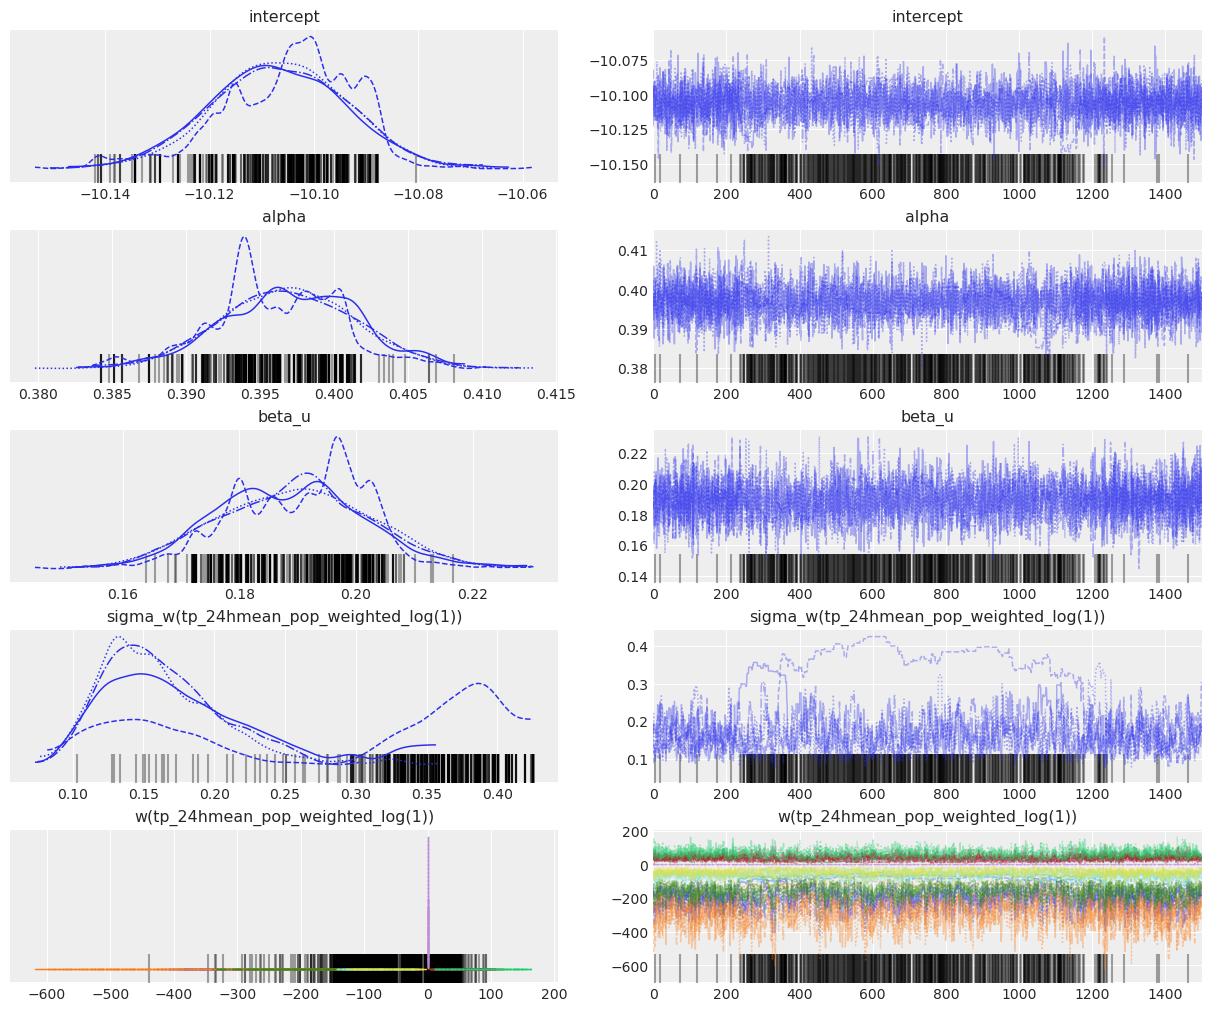

In [21]:
for model_name in model.keys():
    print(model_name)
    # 0.01
    var_names = ['intercept', 'alpha', 'beta_u'] + [f'sigma_w({stat_name})' for stat_name in stat_names] + [f'w({stat_name})' for stat_name in stat_names]
    display(az.summary(idata[model_name], var_names=var_names))
    az.plot_trace(idata[model_name], var_names=var_names);

In [15]:
idata

{}

/mnt/b1/lucaratzinger/Codes/p-dengue/_fitting/fitting_utils.py:521: RuntimeWarning: Mean of empty slice.
  f_s1_mean = f_s1_samples.mean(axis=1)
/mnt/b1/lucaratzinger/miniconda3/envs/p-dengue-py311/lib/python3.11/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


IndexError: index -1 is out of bounds for axis 0 with size 0

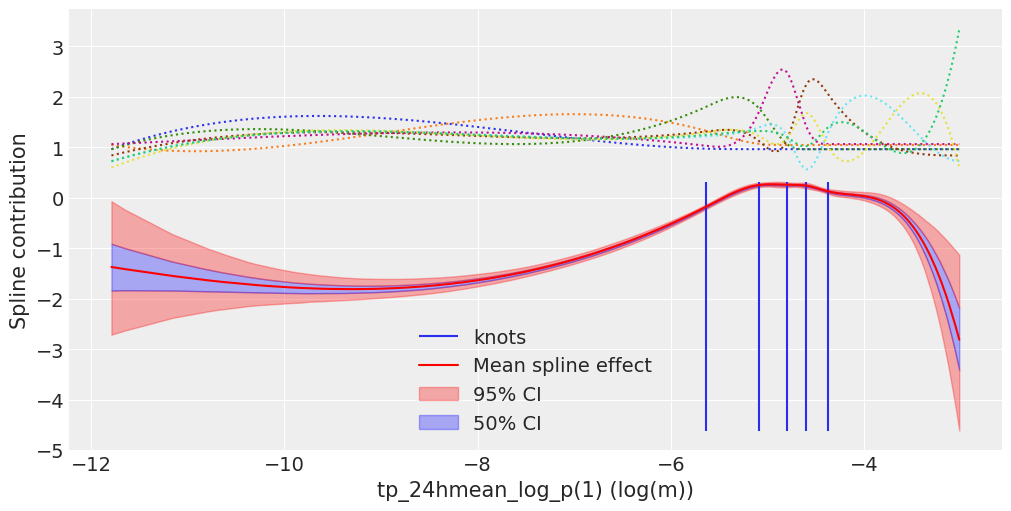

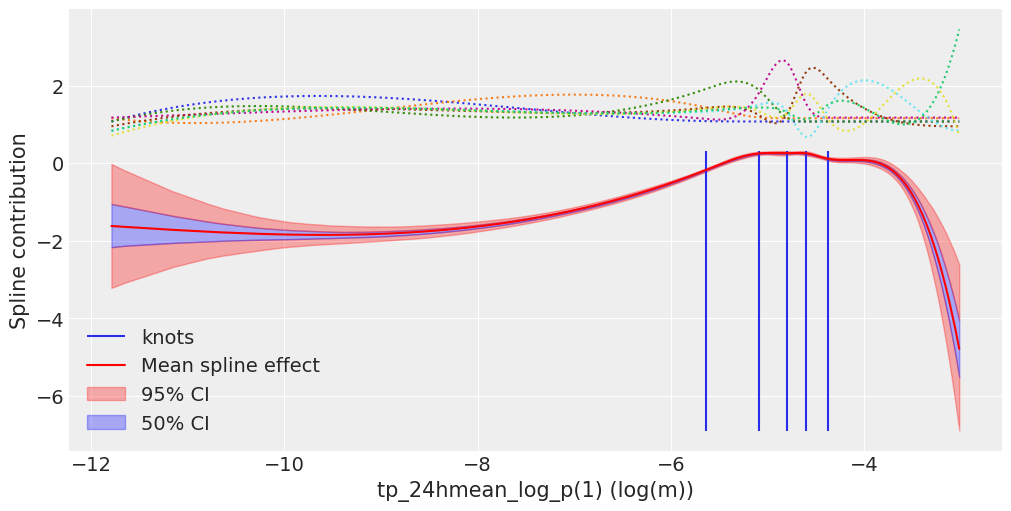

In [22]:
for model_name in model.keys():
    for stat_name in model_settings[model_name]['stat_names']:
        plot_spline(idata[model_name], stat_name, f'w({stat_name})', f'sigma_w({stat_name})',
                    model_B[model_name][stat_name], data[stat_name],
                    knots=model_knot_list[model_name][stat_name],
                    show_basis=True, basis_scale=8, invert_log=False)